In [1]:
import numpy as np
import pandas as pd

import pyspark as ps
from pyspark.sql import SparkSession
import pyspark.sql.functions as F
from pyspark.mllib.recommendation import ALS, MatrixFactorizationModel, Rating

import matplotlib.pyplot as plt

Initialize Spark Context

In [2]:
spark = ps.sql.SparkSession.builder \
            .master("local[2]") \
            .appName("matrix factorization") \
            .getOrCreate()

sc = spark.sparkContext

Read in data

In [3]:
ratings = spark.read \
    .options(inferSchema=True, delimiter=',', header=True) \
    .csv('../data/movies/ratings.csv')

In [4]:
ratings = ratings.drop('timestamp')

In [5]:
ratings.take(2)

[Row(userId=1, movieId=31, rating=2.5),
 Row(userId=1, movieId=1029, rating=3.0)]

# Try training basic ALS model
Reference: https://spark.apache.org/docs/latest/mllib-collaborative-filtering.html

In [6]:
ratings = ratings.rdd

In [7]:
# Build the recommendation model using Alternating Least Squares
rank = 10
numIterations = 10
model = ALS.train(ratings, rank, numIterations)

# Evaluate the model on training data
testdata = ratings.map(lambda p: (p[0], p[1]))
predictions = model.predictAll(testdata).map(lambda r: ((r[0], r[1]), r[2]))
ratesAndPreds = ratings.map(lambda r: ((r[0], r[1]), r[2])).join(predictions)
MSE = ratesAndPreds.map(lambda r: (r[1][0] - r[1][1])**2).mean()
print("Mean Squared Error = " + str(MSE))

Mean Squared Error = 0.2747575481515253


In [57]:
print(f"RMSE = {np.sqrt(MSE)}")

RMSE = 0.5238194154903367


## See if the predictions make sense

In [77]:
user_ratings = np.array(ratings.map(lambda r: r[2]).collect())
print("Sample actual user ratings:", user_ratings[:10])

Sample actual user ratings: [2.5 3.  3.  2.  4.  2.  2.  2.  3.5 2. ]


In [78]:
user_predictions = np.array(predictions.sortBy(lambda x: x[0]).map(lambda x: x[1]).collect())
print("Sample user predictions:", user_predictions[:10].round(1))

Sample user predictions: [2.3 2.9 2.7 2.2 3.7 2.2 2.4 2.2 3.5 2. ]


In [80]:
predicted_minus_actual = (user_predictions - user_ratings).round(1)
print("Sample difference between predicted and actual:", predicted_minus_actual[:10])

Sample difference between predicted and actual: [-0.2 -0.1 -0.3  0.2 -0.3  0.2  0.4  0.2 -0.  -0. ]


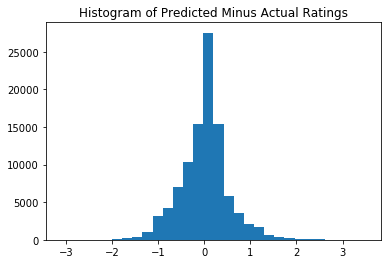

In [82]:
_ = plt.hist(sorted(predicted_minus_actual), bins=30)
_ = plt.title("Histogram of Predicted Minus Actual Ratings")